Problématique

Analyse de différents types de tanks  permet d'avoir de meilleures information sur le matériel utilisé/perdu lors d'une guerre

In [1]:
!pip install -Uq fastai

# Installation de duckduckgo_search permet la recherche d'images 
!pip install -Uqq duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [27]:
# cette méthode nous permet de récuperer une images avec le tag entre crochet (on ne recherche qu'une image a l'aide du max_images)
image = search_images('tank T-72 image', max_images=1)
image[0]

'https://nationalinterest.org/sites/default/files/main_images/14896536271_6d18b62349_o.jpg'

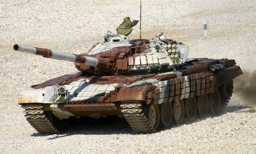

In [32]:
# dl et affichage de l'image
from fastdownload import download_url
dtest = 'tankT72.jpg'
download_url(image[0], dtest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dtest)
im.to_thumb(256,256)

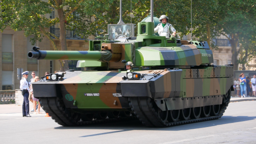

In [21]:
# On fait de même avec les mots-clés : "anime", "fan" et "art". On télécharge et on affiche l'image
download_url(search_images('tank leclerc', max_images=2)[1], 'tankleclerc.jpg', show_progress=False)
Image.open('tankleclerc.jpg').to_thumb(256,256)

path = Path('whichTankIsIt')

In [11]:
# mots clés pour la recherche 
path = Path('whichTankIsIt')
searches = 'russian t-72','tank leclerc'

# import sleep pour faire une pause entre chaque dl pour éviter le surchargement du serveur
from time import sleep

# téléchargement des images
for o in searches:
    dtest = (path/o)
    dtest.mkdir(exist_ok=True, parents=True)
    download_images(dtest, urls=search_images(o))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

on nettoie les données (toutes les images non-dl)

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

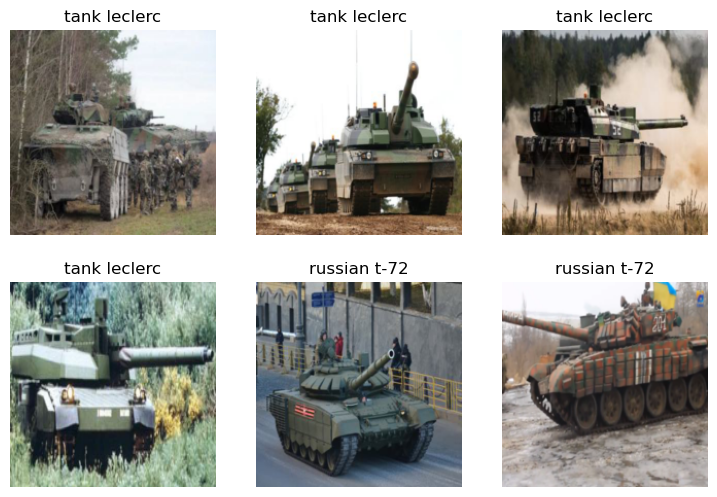

In [13]:
# On construit notre dataloader pour pouvoir entraîner nos données
dls = DataBlock(
    # Première variable : variable indépendante utilisé pour faire la prédiction (des images)
    # Deuxième variable :  variable dépendante utilsé pour les catégories
    blocks=(ImageBlock, CategoryBlock), 
    # On lui donne nos images
    get_items=get_image_files, 
    # On split les données en 2, avec les données d'entraînement et de validation
    # randomSplitter permet de varier les données d'entraînement 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # On précise que nos données sont labelisé par le nom du dossier dans lequel il est
    get_y=parent_label,
    # On change la taille de nos images
    item_tfms=[Resize(200, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

on entraine le model a l'aide du reseau de neurone de type resnet18 (un des types les plus éfficace)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\quentin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\quentin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.407173,0.504516,0.218750,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.430197,0.392169,0.156250,00:11
1,0.260851,0.367665,0.109375,00:11
2,0.179133,0.371201,0.109375,00:12


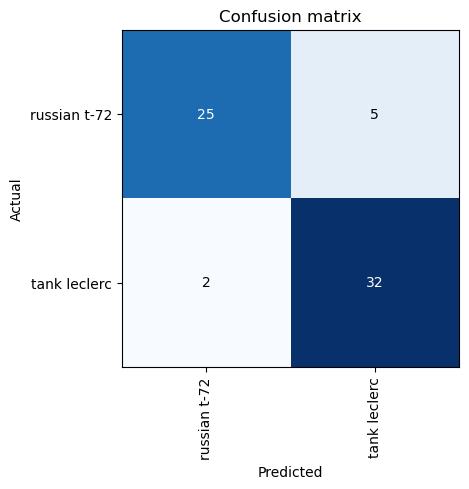

In [16]:
# On vérifie si le model fonctionne à l'aide d'une matrice de confusion, on remarque que notre model détecte correctement 
# faire une matrice de confusion nous permet de vérifier l'éfficacité de notre model il y'a quelques erreurs et c'est normal
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

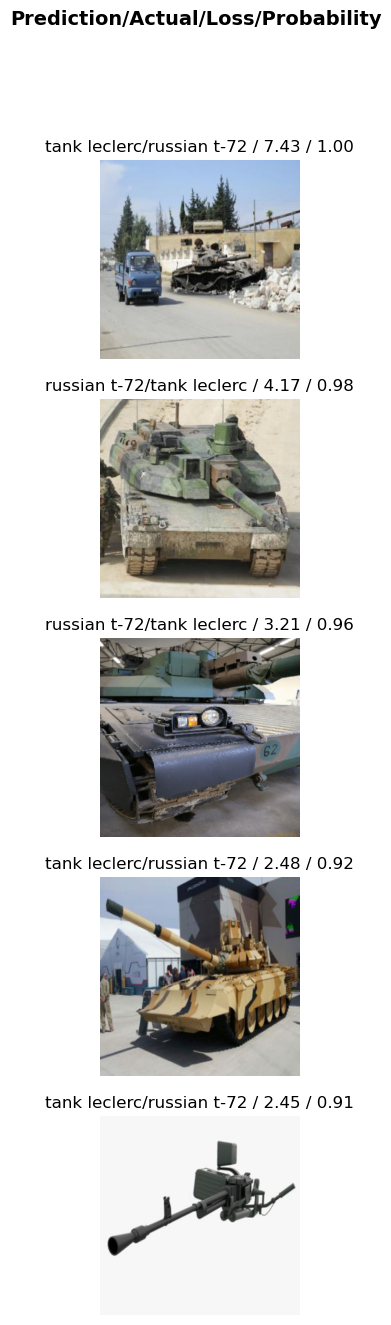

In [17]:
# cette fonction permet de connaitre les images qui créer le plus de difficulté a notre algo
# comme les images sont récupérer automatiquement il est normal d'avoir une qualité d'image parfois mauvaise
interp.plot_top_losses(5, nrows=5)

Maintenant on va vérifier la pertinance de notre model a l'aide des images téléchargé au début

In [34]:
tankType,_,probs = learn.predict(PILImage.create('tankT72.jpg')) # on fait une prédiction sur notre première image téléchargé
print(f"This is a: {tankType}.")
print(f"Probability it's a {tankType} image: {probs[1]:.4f}")

This is a: russian t-72.
Probability it's a russian t-72 image: 0.0657


In [36]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
learn_inf = load_learner(path/'export.pkl')

In [38]:
learn_inf.predict(path/'tankT72.jpg')

('russian t-72', TensorBase(0), TensorBase([0.9343, 0.0657]))

In [39]:
learn_inf.dls.vocab  #liste des catégorie du modèle

['russian t-72', 'tank leclerc']

In [44]:
pip install gradio

     --------------------------------------- 14.2/14.2 MB 59.4 MB/s eta 0:00:00
     ---------------------------------------- 55.6/55.6 kB ? eta 0:00:00
     ---------------------------------------- 323.5/323.5 kB ? eta 0:00:00
     ---------------------------------------- 56.9/56.9 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.7/1.7 MB 107.5 MB/s eta 0:00:00
     ------------------------------------- 812.8/812.8 kB 50.2 MB/s eta 0:00:00
     ---------------------------------------- 195.4/195.4 kB ? eta 0:00:00
     ---------------------------------------- 101.4/101.4 kB ? eta 0:00:00
     ---------------------------------------- 84.5/84.5 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 71.5/71.5 kB ? eta 0:00:00
     ----------------------------------

In [46]:
import gradio as gr

learn = load_learner('export.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "find differents type of tank"
description = "<p style='text-align: center'>Identitifer des tank t72 contre des char leclerc.</p>"

demo = gr.Interface(fn=predict, title=title, description=description, examples = [path/'tankT72.jpg', path/'tankleclerc.jpg'], inputs=gr.Image(shape=(512, 512)), outputs=gr.Label(num_top_classes=2))

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link, please check your internet connection.
